Fork from **Andrew Lukyanenko**

This kernel is still a draft.

Uses OpenBabel API. 
Idea from https://www.kaggle.com/c/champs-scalar-coupling/discussion/93928#latest-546589

With Openbabel it's easy to navigate through bonds, so I added sp, 2J angle and 3J dihedral angle.

Some basic info here https://yvesrubin.files.wordpress.com/2011/03/coupling-constants-for-1h-and-13c-nmr.pdf

What to do next?
If you are a python fan, you certainly can improve my code!

If you are a chemist, you may extract more useful info from openbabel.

if you aren in ML, extracting *everything* from openbabel and create a data file might work. I also did a learning for each bond, but not sure it's good.

## General information

This kernel is created using data of `Predicting Molecular Properties` competition.
We have information about atom couples in molecules and need to predict `scalar_coupling_constant` between these atoms.

![](http://www.et.byu.edu/~rowley/VLEfinal/methane_dimer.gif)

In this kernel I'll do EDA and will try some approaches to modelling.

*Work still in progress*




In [1]:
!ls ../input/

dipole_moments.csv		sample_submission.csv		   test.csv
magnetic_shielding_tensors.csv	scalar_coupling_contributions.csv  train.csv
mulliken_charges.csv		structures
potential_energy.csv		structures.csv


In [2]:
!conda install -y -c openbabel openbabel 
import openbabel


Solving environment: done

## Package Plan ##

  environment location: /opt/conda

  added / updated specs:
    - openbabel


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    ca-certificates-2019.5.15  |                0         133 KB
    libgcc-7.2.0               |       h69d50b8_2         304 KB
    openbabel-2.4.1            |           py36_5         5.1 MB  openbabel
    openssl-1.0.2s             |       h7b6447c_0         3.1 MB
    ------------------------------------------------------------
                                           Total:         8.7 MB

The following NEW packages will be INSTALLED:

  libgcc             pkgs/main/linux-64::libgcc-7.2.0-h69d50b8_2
  openbabel          openbabel/linux-64::openbabel-2.4.1-py36_5

The following packages will be UPDATED:

  ca-certificates                               2019.1.23-0 --> 2019.5.15-0
  openssl                         

In [3]:
#!rm -r /opt/conda/lib/python3.6/site-packages/lightgbm
#!git clone --recursive https://github.com/Microsoft/LightGBM
#!apt-get install -y -qq libboost-all-dev    

In [4]:
#%%bash
#cd LightGBM
#rm -r build
#mkdir build
#cd build
#cmake -DUSE_GPU=1 -DOpenCL_LIBRARY=/usr/local/cuda/lib64/libOpenCL.so -DOpenCL_INCLUDE_DIR=/usr/local/cuda/include/ ..
#make -j$(nproc)

In [5]:
#!cd LightGBM/python-package/;python3 setup.py install --precompile

In [6]:
#!mkdir -p /etc/OpenCL/vendors && echo "libnvidia-opencl.so.1" > /etc/OpenCL/vendors/nvidia.icd
#!rm -r LightGBM

importing libraries

In [7]:
import numpy as np
import pandas as pd
import os

import matplotlib.pyplot as plt
%matplotlib inline
from tqdm import tqdm_notebook
from sklearn.preprocessing import StandardScaler
from sklearn.svm import NuSVR, SVR
from sklearn.metrics import mean_absolute_error
pd.options.display.precision = 15

import lightgbm as lgb
import xgboost as xgb
import time
import datetime
from catboost import CatBoostRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold, KFold, RepeatedKFold
from sklearn import metrics
from sklearn import linear_model
import gc
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

from IPython.display import HTML
import json
import altair as alt

import networkx as nx
import matplotlib.pyplot as plt
%matplotlib inline

alt.renderers.enable('notebook')

os.environ["TZ"]="Europe/Paris"
time.tzset()

In [8]:
# from https://www.kaggle.com/artgor/artgor-utils
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df
    


## Data loading and overview

In [9]:
train = pd.read_csv('../input/train.csv')
test = pd.read_csv('../input/test.csv')
sub = pd.read_csv('../input/sample_submission.csv')

In [10]:
print(f'There are {train.shape[0]} rows in train data.')
print(f'There are {test.shape[0]} rows in test data.')

print(f"There are {train['molecule_name'].nunique()} distinct molecules in train data.")
print(f"There are {test['molecule_name'].nunique()} distinct molecules in test data.")
print(f"There are {train['atom_index_0'].nunique()} unique atoms.")
print(f"There are {train['type'].nunique()} unique types.")

There are 4658147 rows in train data.
There are 2505542 rows in test data.
There are 85003 distinct molecules in train data.
There are 45772 distinct molecules in test data.
There are 29 unique atoms.
There are 8 unique types.


In [11]:
train.head()

,id,molecule_name,atom_index_0,atom_index_1,type,scalar_coupling_constant
0,0,dsgdb9nsd_000001,1,0,1JHC,84.807599999999994
1,1,dsgdb9nsd_000001,1,2,2JHH,-11.257000000000000
2,2,dsgdb9nsd_000001,1,3,2JHH,-11.254799999999999
3,3,dsgdb9nsd_000001,1,4,2JHH,-11.254300000000001
4,4,dsgdb9nsd_000001,2,0,1JHC,84.807400000000001


So in out main data files we have information about moleculas and pairs of atoms
- test set in ~2 times smaller that train set;
- we have 29 unique atoms types and 8 coupling types;

In [12]:
train.describe()

,id,atom_index_0,atom_index_1,scalar_coupling_constant
count,4.658147000000000e+06,4.658147000000000e+06,4.658147000000000e+06,4.658147000000000e+06
mean,2.329073000000000e+06,1.335688568866547e+01,5.883966306773917e+00,1.592164991825936e+01
std,1.344691356527209e+06,3.267712409449629e+00,4.993943098105586e+00,3.494197741570011e+01
min,0.000000000000000e+00,0.000000000000000e+00,0.000000000000000e+00,-3.621860000000000e+01
25%,1.164536500000000e+06,1.100000000000000e+01,2.000000000000000e+00,-2.549780000000000e-01
50%,2.329073000000000e+06,1.300000000000000e+01,5.000000000000000e+00,2.281130000000000e+00
75%,3.493609500000000e+06,1.600000000000000e+01,8.000000000000000e+00,7.390655000000000e+00
max,4.658146000000000e+06,2.800000000000000e+01,2.800000000000000e+01,2.048800000000000e+02


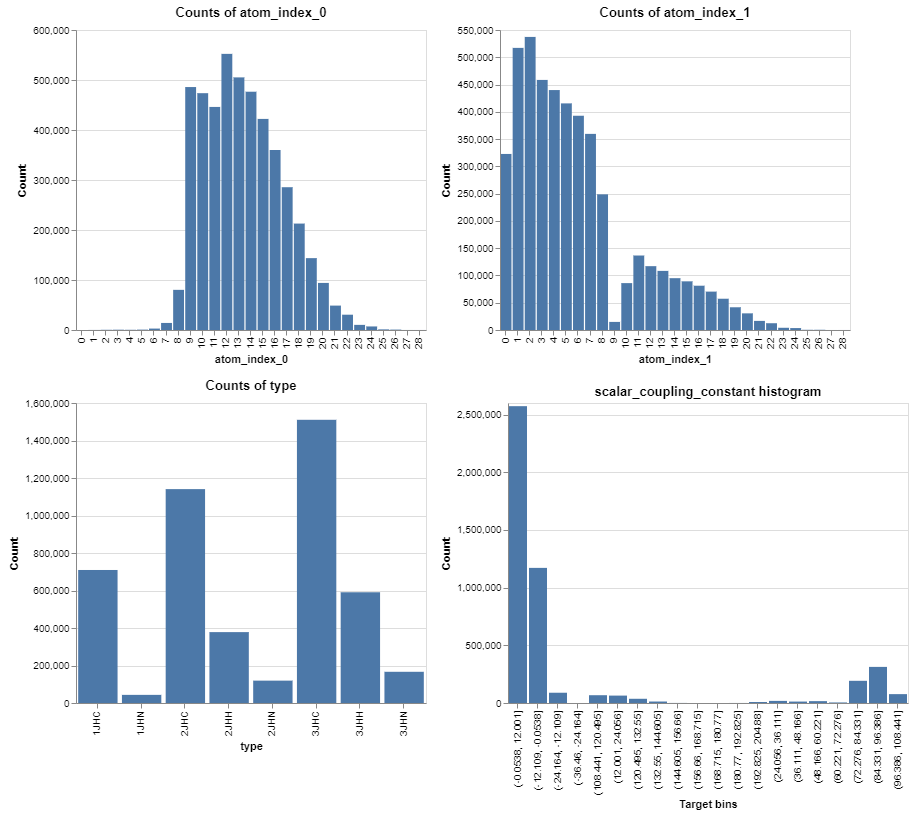

In [13]:
atom_count = train['atom_index_0'].value_counts().reset_index().rename(columns={'atom_index_0': 'count', 'index': 'atom_index_0'})
chart1 = alt.Chart(atom_count).mark_bar().encode(
    x=alt.X("atom_index_0:N", axis=alt.Axis(title='atom_index_0')),
    y=alt.Y('count:Q', axis=alt.Axis(title='Count')),
    tooltip=['atom_index_0', 'count']
).properties(title="Counts of atom_index_0", width=350).interactive()

atom_count = train['atom_index_1'].value_counts().reset_index().rename(columns={'atom_index_1': 'count', 'index': 'atom_index_1'})
chart2 = alt.Chart(atom_count).mark_bar().encode(
    x=alt.X("atom_index_1:N", axis=alt.Axis(title='atom_index_1')),
    y=alt.Y('count:Q', axis=alt.Axis(title='Count')),
    tooltip=['atom_index_1', 'count']
).properties(title="Counts of atom_index_1", width=350).interactive()

type_count = train['type'].value_counts().reset_index().rename(columns={'type': 'count', 'index': 'type'})
chart3 = alt.Chart(type_count).mark_bar().encode(
    x=alt.X("type:N", axis=alt.Axis(title='type')),
    y=alt.Y('count:Q', axis=alt.Axis(title='Count')),
    tooltip=['type', 'count']
).properties(title="Counts of type", width=350).interactive()

hist_df = pd.cut(train['scalar_coupling_constant'], 20).value_counts().sort_index().reset_index().rename(columns={'index': 'bins'})
hist_df['bins'] = hist_df['bins'].astype(str)
chart4 = alt.Chart(hist_df).mark_bar().encode(
    x=alt.X("bins:O", axis=alt.Axis(title='Target bins')),
    y=alt.Y('scalar_coupling_constant:Q', axis=alt.Axis(title='Count')),
    tooltip=['scalar_coupling_constant', 'bins']
).properties(title="scalar_coupling_constant histogram", width=400).interactive()


(chart1 | chart2) & (chart3 | chart4)

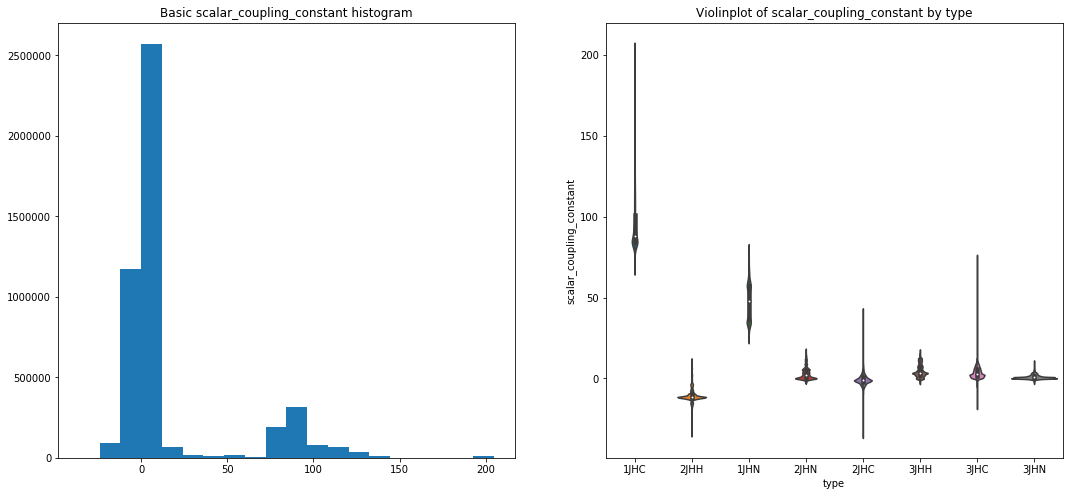

In [14]:
fig, ax = plt.subplots(figsize = (18, 8))
plt.subplot(1, 2, 1);
plt.hist(train['scalar_coupling_constant'], bins=20);
plt.title('Basic scalar_coupling_constant histogram');
plt.subplot(1, 2, 2);
sns.violinplot(x='type', y='scalar_coupling_constant', data=train);
plt.title('Violinplot of scalar_coupling_constant by type');

There are many interesting things here:
- among first atoms there is a little number of atoms with index lower than 7 or higher than 24;
- among second atoms there is a little number of atoms with index higher than 24. Also index with atom with index 9 in quite rare;
- coupling types are unevenly distributed. There are 3 very popular, 3 quite rare and 2 with medium frequency;
- target variable has a bimodal distribution;
- different coupling types have really different values of target variable. Maybe it would make sense to build separate models for each of them;

## Plotting network graphs by type

We have molecules, atom pairs, so this means data, which is interconnected. Network graphs should be useful to visualize such data!

## Better network graphs
But there is a little problem: as we saw earlier, there are atoms which are very rare, as a result graphs will be skewed due to them. Now I'll drop atoms for each type which are present in less then 1% of connections

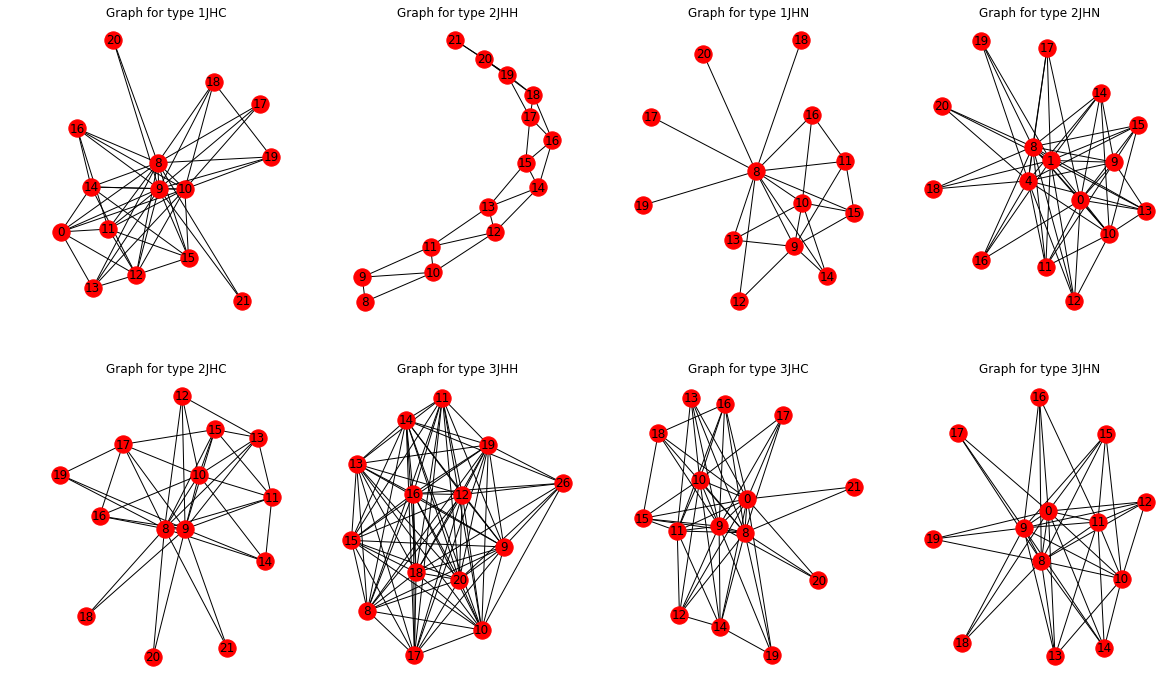

In [15]:
fig, ax = plt.subplots(figsize = (20, 12))
for i, t in enumerate(train['type'].unique()):
    train_type = train.loc[train['type'] == t]
    bad_atoms_0 = list(train_type['atom_index_0'].value_counts(normalize=True)[train_type['atom_index_0'].value_counts(normalize=True) < 0.01].index)
    bad_atoms_1 = list(train_type['atom_index_1'].value_counts(normalize=True)[train_type['atom_index_1'].value_counts(normalize=True) < 0.01].index)
    bad_atoms = list(set(bad_atoms_0 + bad_atoms_1))
    train_type = train_type.loc[(train_type['atom_index_0'].isin(bad_atoms_0) == False) & (train_type['atom_index_1'].isin(bad_atoms_0) == False)]
    G = nx.from_pandas_edgelist(train_type, 'atom_index_0', 'atom_index_1', ['scalar_coupling_constant'])
    plt.subplot(2, 4, i + 1);
    nx.draw(G, with_labels=True);
    plt.title(f'Graph for type {t}')

Now the graphs are much more clear!

## Feature engineering

For now I'll use a basic approach to feature engineering.

I'll use this useful kernel:
https://www.kaggle.com/seriousran/just-speed-up-calculate-distance-from-benchmark

In [16]:
structures = pd.read_csv('../input/structures.csv')

def map_atom_info(df, atom_idx):
    df = pd.merge(df, structures, how = 'left',
                  left_on  = ['molecule_name', f'atom_index_{atom_idx}'],
                  right_on = ['molecule_name',  'atom_index'])
    
    df = df.drop('atom_index', axis=1)
    df = df.rename(columns={'atom': f'atom_{atom_idx}',
                            'x': f'x_{atom_idx}',
                            'y': f'y_{atom_idx}',
                            'z': f'z_{atom_idx}'})
    return df

train = map_atom_info(train, 0)
train = map_atom_info(train, 1)

test = map_atom_info(test, 0)
test = map_atom_info(test, 1)

atom_count=structures.groupby(['molecule_name','atom']).size().unstack(fill_value=0)
train=pd.merge(train,atom_count, how = 'left', left_on  = 'molecule_name', right_on = 'molecule_name')
test=pd.merge(test,atom_count, how = 'left', left_on  = 'molecule_name', right_on = 'molecule_name')

In [17]:
train.head()

,id,molecule_name,atom_index_0,atom_index_1,type,scalar_coupling_constant,atom_0,x_0,y_0,z_0,atom_1,x_1,y_1,z_1,C,F,H,N,O
0,0,dsgdb9nsd_000001,1,0,1JHC,84.807599999999994,H,0.002150416,-0.0060313176,0.0019761204,C,-0.0126981359,1.085804158,0.0080009958,1,0,4,0,0
1,1,dsgdb9nsd_000001,1,2,2JHH,-11.257000000000000,H,0.002150416,-0.0060313176,0.0019761204,H,1.0117308430,1.463751162,0.0002765748,1,0,4,0,0
2,2,dsgdb9nsd_000001,1,3,2JHH,-11.254799999999999,H,0.002150416,-0.0060313176,0.0019761204,H,-0.5408150690,1.447526614,-0.8766437152,1,0,4,0,0
3,3,dsgdb9nsd_000001,1,4,2JHH,-11.254300000000001,H,0.002150416,-0.0060313176,0.0019761204,H,-0.5238136345,1.437932644,0.9063972942,1,0,4,0,0
4,4,dsgdb9nsd_000001,2,0,1JHC,84.807400000000001,H,1.011730843,1.4637511620,0.0002765748,C,-0.0126981359,1.085804158,0.0080009958,1,0,4,0,0


**Creating mol reference with OpenBabel**

In [18]:
%%time
obConversion = openbabel.OBConversion()
obConversion.SetInFormat("xyz")

structdir='../input/structures/'
mols=[]
mols_files=os.listdir(structdir)
mols_index=dict(map(reversed,enumerate(mols_files)))
for f in mols_index.keys():
    mol = openbabel.OBMol()
    obConversion.ReadFile(mol, structdir+f) 
    mols.append(mol)
    

CPU times: user 57.8 s, sys: 20.4 s, total: 1min 18s
Wall time: 2min 34s


In [19]:
def Atoms(molname,AtomId1,AtomId2):
    mol=mols[mols_index[molname+'.xyz']]
    return mol, mol.GetAtomById(AtomId1), mol.GetAtomById(AtomId2)

def SecondAtom(bond,FirstAtom):
    if FirstAtom.GetId()==bond.GetBeginAtom().GetId(): return bond.GetEndAtom()
    else: return bond.GetBeginAtom()

def Angle2J(molname,AtomId1,AtomId2,debug=False):
    mol,firstAtom,lastAtom=Atoms(molname,AtomId1,AtomId2)
    if debug: print (mol.GetFormula())
    if debug: print(firstAtom.GetType(),firstAtom.GetId(),':',lastAtom.GetType(),lastAtom.GetId())
    for b in openbabel.OBAtomBondIter(firstAtom): # all bonds for first atom
      secondAtom=SecondAtom(b,firstAtom)
      lastBond=secondAtom.GetBond(lastAtom)
      if lastBond: # found!
        if debug: print('middle',secondAtom.GetId(),secondAtom.GetType())
        return firstAtom.GetAngle(secondAtom,lastAtom)

Angle2J('dsgdb9nsd_000003',1,2,debug=True) #water

H2O
HO 1 : HO 2
middle 0 O3


103.71576124592411

In [20]:
def Torsion3J(molname,AtomId1,AtomId2,debug=False):
    mol,firstAtom,lastAtom=Atoms(molname,AtomId1,AtomId2)
    if debug: print (molname, mol.GetFormula())
    if debug: print(firstAtom.GetType(),firstAtom.GetId(),':',lastAtom.GetType(),lastAtom.GetId())
    for b in openbabel.OBAtomBondIter(firstAtom): # all bonds for first atom
      secondAtom=SecondAtom(b,firstAtom)
      for b2 in openbabel.OBAtomBondIter(secondAtom): # all bonds for second atom 
        thirdAtom=SecondAtom(b2,secondAtom)
        lastBond=thirdAtom.GetBond(lastAtom)
        if lastBond: # found!
          if debug: print(secondAtom.GetType(),secondAtom.GetId(),'<->',thirdAtom.GetType(),thirdAtom.GetId())
          return mol.GetTorsion(firstAtom,secondAtom,thirdAtom,lastAtom)
          
Torsion3J('dsgdb9nsd_000007',2,5,debug=True) #methanol

dsgdb9nsd_000007 C2H6
H 2 : H 5
C3 0 <-> C3 1


60.00280550635594

In [21]:
train['bonds']=train['type'].str[0].astype(int)
test['bonds']=test['type'].str[0].astype(int)

train_p_0 = train[['x_0', 'y_0', 'z_0']].values
train_p_1 = train[['x_1', 'y_1', 'z_1']].values
test_p_0 = test[['x_0', 'y_0', 'z_0']].values
test_p_1 = test[['x_1', 'y_1', 'z_1']].values

train['dist'] = np.linalg.norm(train_p_0 - train_p_1, axis=1)
test['dist'] = np.linalg.norm(test_p_0 - test_p_1, axis=1)
train['abs_dist']=np.linalg.norm(train_p_0-train_p_1,axis=1,ord=1)
test['abs_dist']=np.linalg.norm(test_p_0-test_p_1,axis=1,ord=1)

In [22]:
def dist12(name='xy',a='x',b='y'):
    train_p_0=train[[a+'_0',b+'_0']].values
    train_p_1=train[[a+'_1',b+'_1']].values
    test_p_0=test[[a+'_0',b+'_0']].values
    test_p_1=test[[a+'_1',b+'_1']].values
    
    train[name] = np.linalg.norm(train_p_0 - train_p_1, axis=1)
    test[name] = np.linalg.norm(test_p_0 - test_p_1, axis=1)
    train['abs_'+name]= np.linalg.norm(train_p_0-train_p_1,axis=1,ord=1)
    test['abs_'+name]= np.linalg.norm(test_p_0-test_p_1,axis=1,ord=1)

In [23]:
dist12('dist_xy','x','y')
dist12('dist_xz','x','z')
dist12('dist_yz','y','z')

In [24]:
train.head(5)

,id,molecule_name,atom_index_0,atom_index_1,type,scalar_coupling_constant,atom_0,x_0,y_0,z_0,atom_1,x_1,y_1,z_1,C,F,H,N,O,bonds,dist,abs_dist,dist_xy,abs_dist_xy,dist_xz,abs_dist_xz,dist_yz,abs_dist_yz
0,0,dsgdb9nsd_000001,1,0,1JHC,84.807599999999994,H,0.002150416,-0.0060313176,0.0019761204,C,-0.0126981359,1.085804158,0.0080009958,1,0,4,0,0,1,1.091953059611900,1.1127089029,1.091936438293093,1.1066840275,0.016024313311731,0.0208734273,1.091852098455768,1.0978603510
1,1,dsgdb9nsd_000001,1,2,2JHH,-11.257000000000000,H,0.002150416,-0.0060313176,0.0019761204,H,1.0117308430,1.463751162,0.0002765748,1,0,4,0,0,2,1.783119756038801,2.4810624522,1.783118946094350,2.4793629066,1.009581857521592,1.0112799726,1.469783462212843,1.4714820252
2,2,dsgdb9nsd_000001,1,3,2JHH,-11.254799999999999,H,0.002150416,-0.0060313176,0.0019761204,H,-0.5408150690,1.447526614,-0.8766437152,1,0,4,0,0,2,1.783147496403011,2.8751432522,1.551657880596930,1.9965234166,1.032852522585415,1.4215853206,1.698470922926572,2.3321777672
3,3,dsgdb9nsd_000001,1,4,2JHH,-11.254300000000001,H,0.002150416,-0.0060313176,0.0019761204,H,-0.5238136345,1.437932644,0.9063972942,1,0,4,0,0,2,1.783156685329616,2.8743491859,1.536772626258658,1.9699280121,1.046238902945277,1.4303852243,1.703822051159491,2.3483851354
4,4,dsgdb9nsd_000001,2,0,1JHC,84.807400000000001,H,1.011730843,1.4637511620,0.0002765748,C,-0.0126981359,1.085804158,0.0080009958,1,0,4,0,0,1,1.091951618581363,1.4101004039,1.091924297120763,1.4023759829,1.024458100407177,1.0321533999,0.378025931005217,0.3856714250


So, everyone uses this distance feature, let's have a look at it!

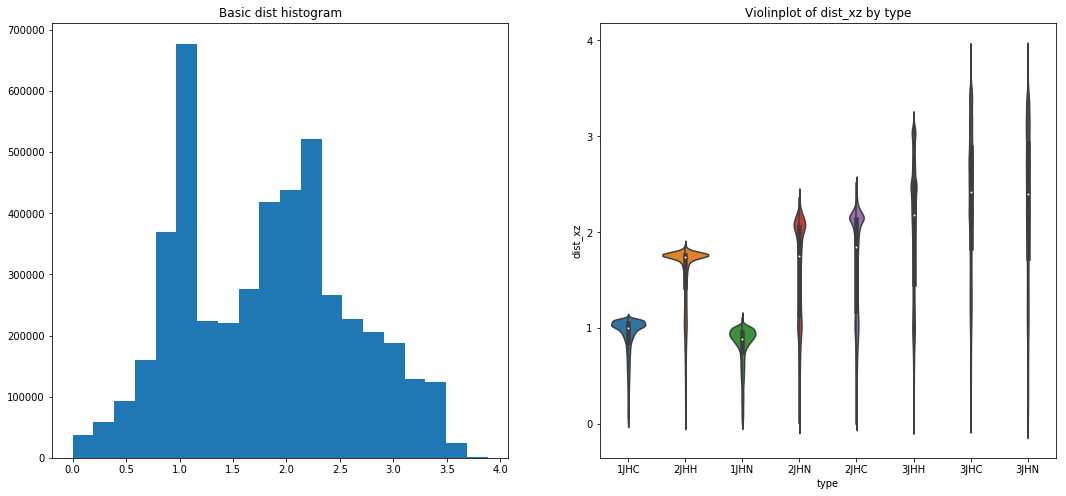

In [25]:
fig, ax = plt.subplots(figsize = (18, 8))
plt.subplot(1, 2, 1);
plt.hist(train['dist_xz'], bins=20);
plt.title('Basic dist histogram');
plt.subplot(1, 2, 2);
sns.violinplot(x='type', y='dist_xz', data=train);
plt.title('Violinplot of dist_xz by type');

It seems that the values are quite different for different types!

In [26]:
train['dist_to_type_mean'] = train['dist'] / train.groupby('type')['dist'].transform('mean')
test['dist_to_type_mean'] = test['dist'] / test.groupby('type')['dist'].transform('mean')

train['dist_to_type_std'] = train['dist'] / train.groupby('type')['dist'].transform('std')
test['dist_to_type_std'] = test['dist'] / test.groupby('type')['dist'].transform('std')

train['dist_to_type_mean_xy'] = train['dist_xy'] / train.groupby('type')['dist_xy'].transform('mean')
test['dist_to_type_mean_xy'] = test['dist_xy'] / test.groupby('type')['dist_xy'].transform('mean')

train['dist_to_type_mean_xz'] = train['dist_xz'] / train.groupby('type')['dist_xz'].transform('mean')
test['dist_to_type_mean_xz'] = test['dist_xz'] / test.groupby('type')['dist_xz'].transform('mean')

train['dist_to_type_mean_yz'] = train['dist_yz'] / train.groupby('type')['dist_yz'].transform('mean')
test['dist_to_type_mean_yz'] = test['dist_yz'] / test.groupby('type')['dist_yz'].transform('mean')

In [27]:
train.head()

,id,molecule_name,atom_index_0,atom_index_1,type,scalar_coupling_constant,atom_0,x_0,y_0,z_0,atom_1,x_1,y_1,z_1,C,F,H,N,O,bonds,dist,abs_dist,dist_xy,abs_dist_xy,dist_xz,abs_dist_xz,dist_yz,abs_dist_yz,dist_to_type_mean,dist_to_type_std,dist_to_type_mean_xy,dist_to_type_mean_xz,dist_to_type_mean_yz
0,0,dsgdb9nsd_000001,1,0,1JHC,84.807599999999994,H,0.002150416,-0.0060313176,0.0019761204,C,-0.0126981359,1.085804158,0.0080009958,1,0,4,0,0,1,1.091953059611900,1.1127089029,1.091936438293093,1.1066840275,0.016024313311731,0.0208734273,1.091852098455768,1.0978603510,0.999133993514757,160.140258468183134,1.308822885399792,0.017808845798591,1.298372056998296
1,1,dsgdb9nsd_000001,1,2,2JHH,-11.257000000000000,H,0.002150416,-0.0060313176,0.0019761204,H,1.0117308430,1.463751162,0.0002765748,1,0,4,0,0,2,1.783119756038801,2.4810624522,1.783118946094350,2.4793629066,1.009581857521592,1.0112799726,1.469783462212843,1.4714820252,1.004633785679569,76.528200864254643,1.420898540772882,0.653242996633718,1.119381740886271
2,2,dsgdb9nsd_000001,1,3,2JHH,-11.254799999999999,H,0.002150416,-0.0060313176,0.0019761204,H,-0.5408150690,1.447526614,-0.8766437152,1,0,4,0,0,2,1.783147496403011,2.8751432522,1.551657880596930,1.9965234166,1.032852522585415,1.4215853206,1.698470922926572,2.3321777672,1.004649414975929,76.529391429362306,1.236456167519326,0.668300120399065,1.293549279488992
3,3,dsgdb9nsd_000001,1,4,2JHH,-11.254300000000001,H,0.002150416,-0.0060313176,0.0019761204,H,-0.5238136345,1.437932644,0.9063972942,1,0,4,0,0,2,1.783156685329616,2.8743491859,1.536772626258658,1.9699280121,1.046238902945277,1.4303852243,1.703822051159491,2.3483851354,1.004654592141451,76.529785801091180,1.224594683901192,0.676961685734461,1.297624679295201
4,4,dsgdb9nsd_000001,2,0,1JHC,84.807400000000001,H,1.011730843,1.4637511620,0.0002765748,C,-0.0126981359,1.085804158,0.0080009958,1,0,4,0,0,1,1.091951618581363,1.4101004039,1.091924297120763,1.4023759829,1.024458100407177,1.0321533999,0.378025931005217,0.3856714250,0.999132674975848,160.140047134004675,1.308808332680748,1.138545907231645,0.449528197392408


In [28]:
#%%time
#### get atom or mol in train?
######train['sp']=train.apply(lambda row: Atoms(row.molecule_name, row.atom_index_0, row.atom_index_1)[2],axis=1) # second atom is C or N for bond 1


In [29]:
def create_features(df):
    df['molecule_couples'] = df.groupby('molecule_name')['id'].transform('count')
    df['molecule_dist_mean'] = df.groupby('molecule_name')['dist'].transform('mean')
    df['molecule_dist_min'] = df.groupby('molecule_name')['dist'].transform('min')
    df['molecule_dist_max'] = df.groupby('molecule_name')['dist'].transform('max')
    df['atom_0_couples_count'] = df.groupby(['molecule_name', 'atom_index_0'])['id'].transform('count')
    df['atom_1_couples_count'] = df.groupby(['molecule_name', 'atom_index_1'])['id'].transform('count')
    
    df[f'molecule_atom_index_0_x_1_std'] = df.groupby(['molecule_name', 'atom_index_0'])['x_1'].transform('std')
    df[f'molecule_atom_index_0_y_1_mean'] = df.groupby(['molecule_name', 'atom_index_0'])['y_1'].transform('mean')
    df[f'molecule_atom_index_0_y_1_mean_diff'] = df[f'molecule_atom_index_0_y_1_mean'] - df['y_1']
    df[f'molecule_atom_index_0_y_1_mean_div'] = df[f'molecule_atom_index_0_y_1_mean'] / df['y_1']
    df[f'molecule_atom_index_0_y_1_max'] = df.groupby(['molecule_name', 'atom_index_0'])['y_1'].transform('max')
    df[f'molecule_atom_index_0_y_1_max_diff'] = df[f'molecule_atom_index_0_y_1_max'] - df['y_1']
    df[f'molecule_atom_index_0_y_1_std'] = df.groupby(['molecule_name', 'atom_index_0'])['y_1'].transform('std')
    df[f'molecule_atom_index_0_z_1_std'] = df.groupby(['molecule_name', 'atom_index_0'])['z_1'].transform('std')
    df[f'molecule_atom_index_0_dist_mean'] = df.groupby(['molecule_name', 'atom_index_0'])['dist'].transform('mean')
    df[f'molecule_atom_index_0_dist_mean_diff'] = df[f'molecule_atom_index_0_dist_mean'] - df['dist']
    df[f'molecule_atom_index_0_dist_mean_div'] = df[f'molecule_atom_index_0_dist_mean'] / df['dist']
    df[f'molecule_atom_index_0_dist_max'] = df.groupby(['molecule_name', 'atom_index_0'])['dist'].transform('max')
    df[f'molecule_atom_index_0_dist_max_diff'] = df[f'molecule_atom_index_0_dist_max'] - df['dist']
    df[f'molecule_atom_index_0_dist_max_div'] = df[f'molecule_atom_index_0_dist_max'] / df['dist']
    df[f'molecule_atom_index_0_dist_min'] = df.groupby(['molecule_name', 'atom_index_0'])['dist'].transform('min')
    df[f'molecule_atom_index_0_dist_min_diff'] = df[f'molecule_atom_index_0_dist_min'] - df['dist']
    df[f'molecule_atom_index_0_dist_min_div'] = df[f'molecule_atom_index_0_dist_min'] / df['dist']
    df[f'molecule_atom_index_0_dist_std'] = df.groupby(['molecule_name', 'atom_index_0'])['dist'].transform('std')
    df[f'molecule_atom_index_0_dist_std_diff'] = df[f'molecule_atom_index_0_dist_std'] - df['dist']
    df[f'molecule_atom_index_0_dist_std_div'] = df[f'molecule_atom_index_0_dist_std'] / df['dist']
    df[f'molecule_atom_index_1_dist_mean'] = df.groupby(['molecule_name', 'atom_index_1'])['dist'].transform('mean')
    df[f'molecule_atom_index_1_dist_mean_diff'] = df[f'molecule_atom_index_1_dist_mean'] - df['dist']
    df[f'molecule_atom_index_1_dist_mean_div'] = df[f'molecule_atom_index_1_dist_mean'] / df['dist']
    df[f'molecule_atom_index_1_dist_max'] = df.groupby(['molecule_name', 'atom_index_1'])['dist'].transform('max')
    df[f'molecule_atom_index_1_dist_max_diff'] = df[f'molecule_atom_index_1_dist_max'] - df['dist']
    df[f'molecule_atom_index_1_dist_max_div'] = df[f'molecule_atom_index_1_dist_max'] / df['dist']
    df[f'molecule_atom_index_1_dist_min'] = df.groupby(['molecule_name', 'atom_index_1'])['dist'].transform('min')
    df[f'molecule_atom_index_1_dist_min_diff'] = df[f'molecule_atom_index_1_dist_min'] - df['dist']
    df[f'molecule_atom_index_1_dist_min_div'] = df[f'molecule_atom_index_1_dist_min'] / df['dist']
    df[f'molecule_atom_index_1_dist_std'] = df.groupby(['molecule_name', 'atom_index_1'])['dist'].transform('std')
    df[f'molecule_atom_index_1_dist_std_diff'] = df[f'molecule_atom_index_1_dist_std'] - df['dist']
    df[f'molecule_atom_index_1_dist_std_div'] = df[f'molecule_atom_index_1_dist_std'] / df['dist']
    df[f'molecule_atom_1_dist_mean'] = df.groupby(['molecule_name', 'atom_1'])['dist'].transform('mean')
    df[f'molecule_atom_1_dist_min'] = df.groupby(['molecule_name', 'atom_1'])['dist'].transform('min')
    df[f'molecule_atom_1_dist_min_diff'] = df[f'molecule_atom_1_dist_min'] - df['dist']
    df[f'molecule_atom_1_dist_min_div'] = df[f'molecule_atom_1_dist_min'] / df['dist']
    df[f'molecule_atom_1_dist_std'] = df.groupby(['molecule_name', 'atom_1'])['dist'].transform('std')
    df[f'molecule_atom_1_dist_std_diff'] = df[f'molecule_atom_1_dist_std'] - df['dist']
    df[f'molecule_bonds_dist_std'] = df.groupby(['molecule_name', 'bonds'])['dist'].transform('std')
    df[f'molecule_bonds_dist_std_diff'] = df[f'molecule_bonds_dist_std'] - df['dist']
    df[f'molecule_type_dist_mean'] = df.groupby(['molecule_name', 'type'])['dist'].transform('mean')
    df[f'molecule_type_dist_mean_diff'] = df[f'molecule_type_dist_mean'] - df['dist']
    df[f'molecule_type_dist_mean_div'] = df[f'molecule_type_dist_mean'] / df['dist']
    df[f'molecule_type_dist_max'] = df.groupby(['molecule_name', 'type'])['dist'].transform('max')
    df[f'molecule_type_dist_min'] = df.groupby(['molecule_name', 'type'])['dist'].transform('min')
    df[f'molecule_type_dist_std'] = df.groupby(['molecule_name', 'type'])['dist'].transform('std')
    df[f'molecule_type_dist_std_diff'] = df[f'molecule_type_dist_std'] - df['dist']

    return df


In [30]:
%%time
train = create_features(train)
test = create_features(test)

train=reduce_mem_usage(train)
test=reduce_mem_usage(test)

Mem. usage decreased to 897.36 Mb (71.0% reduction)
Mem. usage decreased to 468.34 Mb (71.5% reduction)
CPU times: user 1min 33s, sys: 2min 50s, total: 4min 23s
Wall time: 4min 23s


In [31]:
# memory usage
import sys
def sizeof_fmt(num, suffix='B'):
    ''' By Fred Cirera, after https://stackoverflow.com/a/1094933/1870254'''
    for unit in ['','Ki','Mi','Gi','Ti','Pi','Ei','Zi']:
        if abs(num) < 1024.0:
            return "%3.1f%s%s" % (num, unit, suffix)
        num /= 1024.0
    return "%.1f%s%s" % (num, 'Yi', suffix)

for name, size in sorted(((name, sys.getsizeof(value)) for name,value in locals().items()),
                         key= lambda x: -x[1])[:10]:
    print("{:>30}: {:>8}".format(name,sizeof_fmt(size)))

                         train:   1.9GiB
                          test:   1.0GiB
                    structures: 384.6MiB
                           sub:  38.2MiB
                    atom_count:  14.1MiB
                    train_type:   6.1MiB
                    mols_index:   5.0MiB
                          mols:   1.1MiB
                    mols_files:   1.1MiB
                           _ii:   5.3KiB


## Basic model

I'll use the function for metric calculation from this kernel: https://www.kaggle.com/abhishek/competition-metric

In [32]:
def metric(df, preds):
    df["prediction"] = preds
    maes = []
    for t in df.type.unique():
        y_true = df[df.type==t].scalar_coupling_constant.values
        y_pred = df[df.type==t].prediction.values
        mae = np.log(metrics.mean_absolute_error(y_true, y_pred))
        maes.append(mae)
    return np.mean(maes)

In [33]:
def group_mean_log_mae(y_true, y_pred, groups, floor=1e-9):
    maes = (y_true-y_pred).abs().groupby(groups).mean()
    return np.log(maes.map(lambda x: max(x, floor))).mean()

In [34]:
for f in [ 'atom_0', 'atom_1']:
    lbl = LabelEncoder()
    lbl.fit(list(train[f].values) )
    train[f] = lbl.transform(list(train[f].values))
    test[f] = lbl.transform(list(test[f].values))

In [35]:
def train_model(X, X_test, y, params, folds, model_type='lgb', plot_feature_importance=False, model=None):

    oof = np.zeros(len(X))
    print(X.shape,X_test.shape)
    prediction = np.zeros(len(X_test))
    scores = []
    feature_importance = pd.DataFrame()
    for fold_n, (train_index, valid_index) in enumerate(folds.split(X)):
        print('Fold', fold_n, 'started at', time.ctime())
      
        X_train, X_valid = X.iloc[train_index], X.iloc[valid_index]
        y_train, y_valid = y.iloc[train_index], y.iloc[valid_index]
        if model_type == 'lgb':
            model = lgb.LGBMRegressor(**params, n_estimators = 2000, n_jobs = -1)
            model.fit(X_train, y_train, 
                    eval_set=[(X_train, y_train), (X_valid, y_valid)], eval_metric='mae',
                    verbose=500, early_stopping_rounds=200)
            
            y_pred_valid = model.predict(X_valid)
            y_pred = model.predict(X_test, num_iteration=model.best_iteration_)
            
        if model_type == 'xgb':
            train_data = xgb.DMatrix(data=X_train, label=y_train, feature_names=X_tr.columns)
            valid_data = xgb.DMatrix(data=X_valid, label=y_valid, feature_names=X_tr.columns)

            watchlist = [(train_data, 'train'), (valid_data, 'valid_data')]
            model = xgb.train(dtrain=train_data, num_boost_round=20000, evals=watchlist, early_stopping_rounds=200, verbose_eval=500, params=params)
            y_pred_valid = model.predict(xgb.DMatrix(X_valid, feature_names=X_tr.columns), ntree_limit=model.best_ntree_limit)
            y_pred = model.predict(xgb.DMatrix(X_test, feature_names=X_tr.columns), ntree_limit=model.best_ntree_limit)
            
        if model_type == 'rcv':
            model = RidgeCV(alphas=(0.01, 0.1, 1.0, 10.0, 100.0), scoring='neg_mean_absolute_error', cv=3)
            model.fit(X_train, y_train)
            print(model.alpha_)

            y_pred_valid = model.predict(X_valid).reshape(-1,)
            score = mean_absolute_error(y_valid, y_pred_valid)
            print(f'Fold {fold_n}. MAE: {score:.4f}.')
            print('')
            
            y_pred = model.predict(X_test).reshape(-1,)
        
        if model_type == 'sklearn':
            model = model
            model.fit(X_train, y_train)
            
            y_pred_valid = model.predict(X_valid).reshape(-1,)
            score = mean_absolute_error(y_valid, y_pred_valid)
            print(f'Fold {fold_n}. MAE: {score:.4f}.')
            print('')
            
            y_pred = model.predict(X_test).reshape(-1,)
        
        if model_type == 'cat':
            model = CatBoostRegressor(iterations=20000,  eval_metric='MAE', **params)
            model.fit(X_train, y_train, eval_set=(X_valid, y_valid), cat_features=[], use_best_model=True, verbose=False)

            y_pred_valid = model.predict(X_valid)
            y_pred = model.predict(X_test)
        
        oof[valid_index] = y_pred_valid.reshape(-1,)
        scores.append(mean_absolute_error(y_valid, y_pred_valid))

        prediction += y_pred    
        
        if model_type == 'lgb':
            # feature importance
            fold_importance = pd.DataFrame()
            fold_importance["feature"] = X.columns
            fold_importance["importance"] = model.feature_importances_
            fold_importance["fold"] = fold_n + 1
            feature_importance = pd.concat([feature_importance, fold_importance], axis=0)

    prediction /= n_fold
    
    print('CV mean score: {0:.4f}, std: {1:.4f}.'.format(np.mean(scores), np.std(scores)))
    
    if model_type == 'lgb':
        feature_importance["importance"] /= n_fold
        if plot_feature_importance:
            cols = feature_importance[["feature", "importance"]].groupby("feature").mean().sort_values(
                by="importance", ascending=False)[:50].index

            best_features = feature_importance.loc[feature_importance.feature.isin(cols)]

            plt.figure(figsize=(16, 12));
            sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False));
            plt.title('LGB Features (avg over folds)');
        
            return oof, prediction, feature_importance
        return oof, prediction
    
    else:
        return oof, prediction, model

In [36]:
params = {
          'num_leaves': 128,
          'min_child_samples': 50,
          'objective': 'regression',
          'max_depth': 9,
          'learning_rate': 0.2,
          "boosting_type": "gbdt",
          "subsample_freq": 1,
          "subsample": 0.9,
          "bagging_seed": 11,
          "metric": 'mae',
          "verbosity": -1,
          'reg_alpha': 0.1302650970728192,
          'reg_lambda': 0.3603427518866501,
          'colsample_bytree': 1.0,
          'device' : 'cpu',
          'gpu_platform_id' : 0,
          'gpu_device_id' : 0,
          'gpu_use_dp': False
         }

In [ ]:
prediction_lgb=pd.DataFrame(test.shape[0],index=test['id'],columns=['scalar_coupling_constant'],dtype=float)
oof_lgb=pd.DataFrame(train.shape[0],index=train['id'],columns=['oof'],dtype=float)

for t in train['type'].unique():
    print(f'Training of type {t}')
    b=int(t[0]) # current bond for this type
    print('Predicting J=',b)
    X=train[train.type==t]
    if (b==1):
        X['sp']=X.apply(lambda row: Atoms(row.molecule_name, row.atom_index_0, row.atom_index_1)[2].GetHyb(),axis=1) # second atom is C or N for bond 1
    if (b==2):
        X['Angle']=X.apply(lambda row: Angle2J(row.molecule_name , row.atom_index_0, row.atom_index_1),axis=1) 
    if (b==3):
        X['Torsion']=X.apply(lambda row: Torsion3J(row.molecule_name , row.atom_index_0, row.atom_index_1),axis=1) 
        X['cosT']=np.cos(np.deg2rad(X['Torsion']))
        X['cos2T']=np.cos(2*np.deg2rad(X['Torsion']))
    y = X['scalar_coupling_constant']
    ids_train=X['id']
    X = X.drop(['id','type', 'molecule_name', 'scalar_coupling_constant','bonds'], axis=1)
    
    X_test = test[test.type==t]
    if (b==1): 
        X_test['sp']=X_test.apply(lambda row: Atoms(row.molecule_name, row.atom_index_0, row.atom_index_1)[2].GetHyb(),axis=1) # second atom is C or N for bond 1
    if (b==2):
        X_test['Angle']=X_test.apply(lambda row: Angle2J(row.molecule_name , row.atom_index_0, row.atom_index_1),axis=1) 
    if (b==3):
        X_test['Torsion']=X_test.apply(lambda row: Torsion3J(row.molecule_name , row.atom_index_0, row.atom_index_1),axis=1)  
        X_test['cosT']=np.cos(np.deg2rad(X_test['Torsion']))
        X_test['cos2T']=np.cos(2*np.deg2rad(X_test['Torsion']))
    ids_test=X_test['id']    
    X_test=X_test.drop(['id', 'type', 'molecule_name','bonds'], axis=1)
    
    n_fold = 5
    folds = KFold(n_splits=n_fold, shuffle=True, random_state=11)
    
    fold_oof_lgb, fold_prediction_lgb, feature_importance = train_model(X=X,X_test=X_test,y=y,params=params,folds=folds, model_type='lgb', plot_feature_importance=True)
    
    prediction_lgb.loc[ids_test,'scalar_coupling_constant']=fold_prediction_lgb
    oof_lgb.loc[ids_train,'oof']=fold_oof_lgb
      

Training of type 1JHC
Predicting J= 1
(709416, 82) (380609, 82)
Fold 0 started at Sat Jun  8 14:23:27 2019
Training until validation scores don't improve for 200 rounds.
[100]	training's l1: 2.08753	valid_1's l1: 2.19636
[200]	training's l1: 1.82966	valid_1's l1: 2.01051
[300]	training's l1: 1.67875	valid_1's l1: 1.92239
[400]	training's l1: 1.56104	valid_1's l1: 1.86226
[500]	training's l1: 1.46918	valid_1's l1: 1.82178
[600]	training's l1: 1.39124	valid_1's l1: 1.78879
[700]	training's l1: 1.32146	valid_1's l1: 1.76323
[800]	training's l1: 1.2596	valid_1's l1: 1.74281
[900]	training's l1: 1.20342	valid_1's l1: 1.72501
[1000]	training's l1: 1.15259	valid_1's l1: 1.71022
[1100]	training's l1: 1.10547	valid_1's l1: 1.69861
[1200]	training's l1: 1.06226	valid_1's l1: 1.68863
[1300]	training's l1: 1.02093	valid_1's l1: 1.67906
[1400]	training's l1: 0.98345	valid_1's l1: 1.67035
[1500]	training's l1: 0.94799	valid_1's l1: 1.66332
[1600]	training's l1: 0.914166	valid_1's l1: 1.6559
[1700]	t

In [ ]:
#'categorical_feature' : "name:type, atom_0, atom_1",

In [ ]:
sub=sub.drop(['scalar_coupling_constant'],axis=1).merge(prediction_lgb,on='id')
sub.to_csv('submission.csv', index=False)
sub.head()

In [ ]:
plot_data = pd.DataFrame(train['scalar_coupling_constant'])
plot_data.index.name = 'id'
plot_data['yhat'] = oof_lgb['oof']
plot_data['type'] = train['type']

def plot_oof_preds(ctype, llim, ulim):
        plt.figure(figsize=(6,6))
        sns.scatterplot(x='scalar_coupling_constant',y='yhat',
                        data=plot_data.loc[plot_data['type']==ctype,
                        ['scalar_coupling_constant', 'yhat']]);
        plt.xlim((llim, ulim))
        plt.ylim((llim, ulim))
        plt.plot([llim, ulim], [llim, ulim])
        plt.xlabel('scalar_coupling_constant')
        plt.ylabel('predicted')
        plt.title(f'{ctype}', fontsize=18)
        plt.show()

plot_oof_preds('1JHC', 0, 250)
plot_oof_preds('1JHN', 0, 100)
plot_oof_preds('2JHC', -50, 50)
plot_oof_preds('2JHH', -50, 50)
plot_oof_preds('2JHN', -25, 25)
plot_oof_preds('3JHC', -25, 100)
plot_oof_preds('3JHH', -20, 20)
plot_oof_preds('3JHN', -15, 15)